In [122]:
import tensorflow as tf


In [123]:
!nvidia-smi

Sun Apr 20 12:48:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              6W /   40W |    2987MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [124]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [125]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import contextlib
from datetime import datetime
from IPython import get_ipython

In [126]:
import sys
sys.path.append('../../../utils')  # Add the folder to the path
from notebook_saver import NotebookSaver

In [127]:
notebook_saver = NotebookSaver()
save_dir = notebook_saver.get_save_dir()

Save directory created: notebook_versions\20250420_124850_notebookversion


In [128]:
# References: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
DATADIR = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\training_img_dataset\front_dataset\front_micro\dwt_training_picture"
CATEGORIES = ["clap", "punching", "pushpull", "rubhand", "waving"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        break
    break 

In [129]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

In [130]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

print(len(training_data))

100%|██████████| 1210/1210 [00:01<00:00, 789.47it/s]

6094


In [131]:
# import random

# random.shuffle(training_data)

In [132]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [133]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [134]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [135]:
X = X/255.0
y = to_categorical(y, num_classes=5)

In [136]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
cnn = tf.keras.models.Sequential([

    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    # tf.keras.layers.RandomRotation(0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [138]:
cnn.compile(Adam(learning_rate = 0.0001),  
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [139]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [140]:
history = cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

val_loss, val_acc = cnn.evaluate(X_val, y_val) 
print(f"Final Validation Accuracy: {val_acc}")

Epoch 1/10
153/153 [==============================] - 3s 11ms/step - loss: 1.4836 - accuracy: 0.3493 - val_loss: 1.3418 - val_accuracy: 0.4381
Epoch 2/10
153/153 [==============================] - 1s 8ms/step - loss: 1.2789 - accuracy: 0.4669 - val_loss: 1.2508 - val_accuracy: 0.4971
Epoch 3/10
153/153 [==============================] - 1s 8ms/step - loss: 1.1823 - accuracy: 0.5110 - val_loss: 1.1734 - val_accuracy: 0.5021
Epoch 4/10
153/153 [==============================] - 1s 8ms/step - loss: 1.1130 - accuracy: 0.5483 - val_loss: 1.1337 - val_accuracy: 0.5168
Epoch 5/10
153/153 [==============================] - 1s 8ms/step - loss: 1.0670 - accuracy: 0.5758 - val_loss: 1.1158 - val_accuracy: 0.5152
Epoch 6/10
153/153 [==============================] - 1s 8ms/step - loss: 1.0097 - accuracy: 0.6029 - val_loss: 1.0695 - val_accuracy: 0.5398
Epoch 7/10
153/153 [==============================] - 1s 8ms/step - loss: 0.9791 - accuracy: 0.6107 - val_loss: 1.0613 - val_accuracy: 0.5537
Epoch

Plot saved to: notebook_versions\20250420_124850_notebookversion\plot_20250420_124914.png


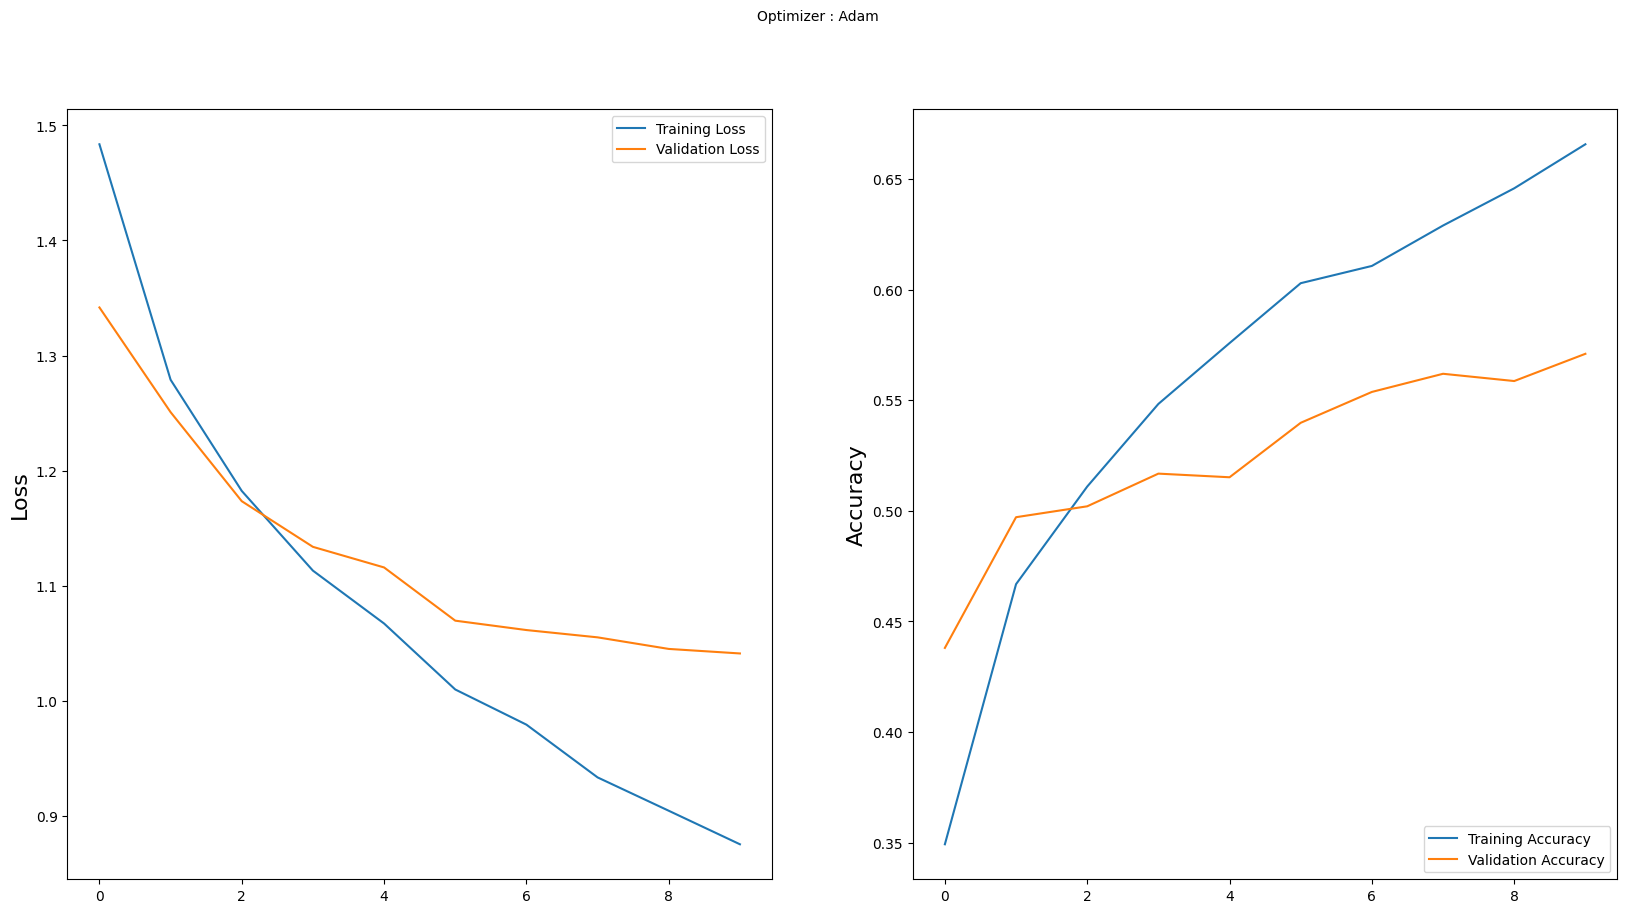

In [141]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
notebook_saver.save_plot(name = 'plot')
plt.show()

39/39 [==============================] - 0s 3ms/step
Plot saved to: notebook_versions\20250420_124850_notebookversion\cm_20250420_124915.png


<Figure size 640x480 with 0 Axes>

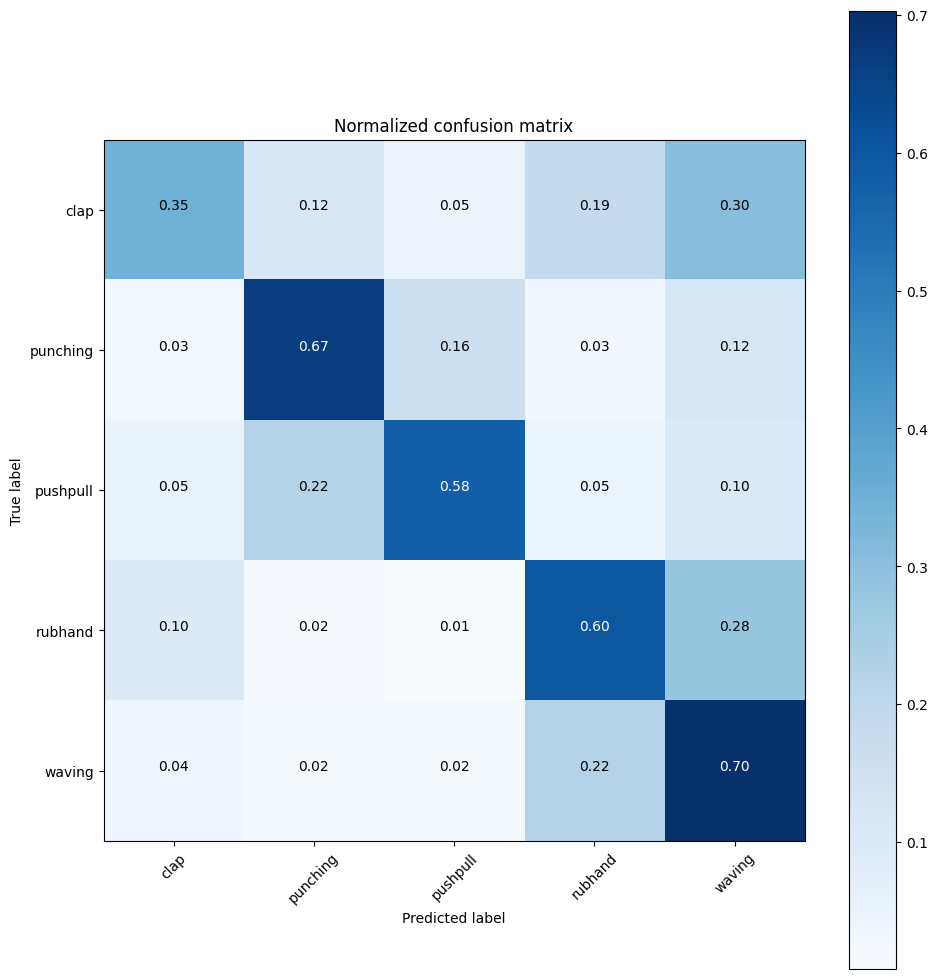

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 12544)             0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [142]:
# Plot confusion matrix:
# Get predictions from the model on the validation set
y_pred_probs = cnn.predict(X_val)

y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_val, axis=1)

# Reference: https://github.com/parisafm/CSI-HAR-Dataset/blob/main/CNN.py
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    notebook_saver.save_plot(name = 'cm')

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=CATEGORIES, title='Normalized confusion matrix')
plt.show()

cnn.summary()

In [143]:
notebook_saver.save_notebook_code()
notebook_saver.save_model_summary(cnn)
notebook_saver.save_training_output(history, val_loss, val_acc)

Notebook code snapshot saved to: notebook_versions\20250420_124850_notebookversion\notebook_code_snapshot.py
Model summary saved to: notebook_versions\20250420_124850_notebookversion\model_summary.txt
Training output saved to: notebook_versions\20250420_124850_notebookversion\training_output.txt
